In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Exploratory Data Analysis (EDA) — Intro Section

The dataset under study has already been preprocessed into **chunked texts** of 300–500 characters, 
resulting in a large corpus suitable for modeling. To handle the heavy dataset efficiently 
(~2.9 million records), we use **PySpark** for data extraction and summarization.

In this introductory stage of EDA, our goals are:
- Describe the **basic shape** of the dataset (total chunk records).
- Count the number of **unique authors** and **unique titles** in the corpus.
- Explore **genre distribution**, with a special focus on "Fantasy" records.
- Provide a few **interesting facts** about the corpus to set the stage for deeper visual analysis.

 Dataset Overview
Total chunked records: 100,000
Unique authors: 5
Unique titles: 369


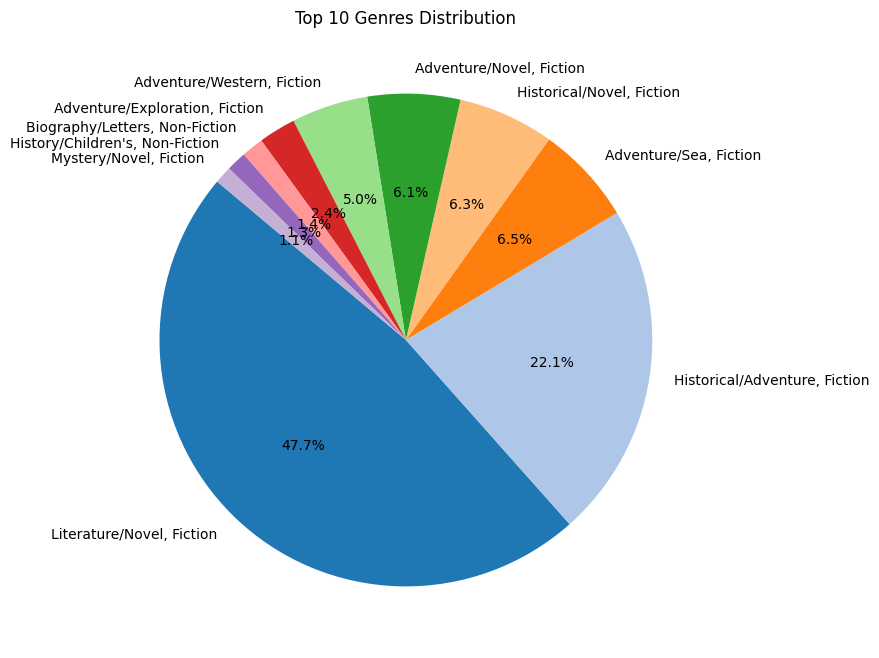

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_6732\217455497.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="author", y="count", data=top_authors, palette="viridis")


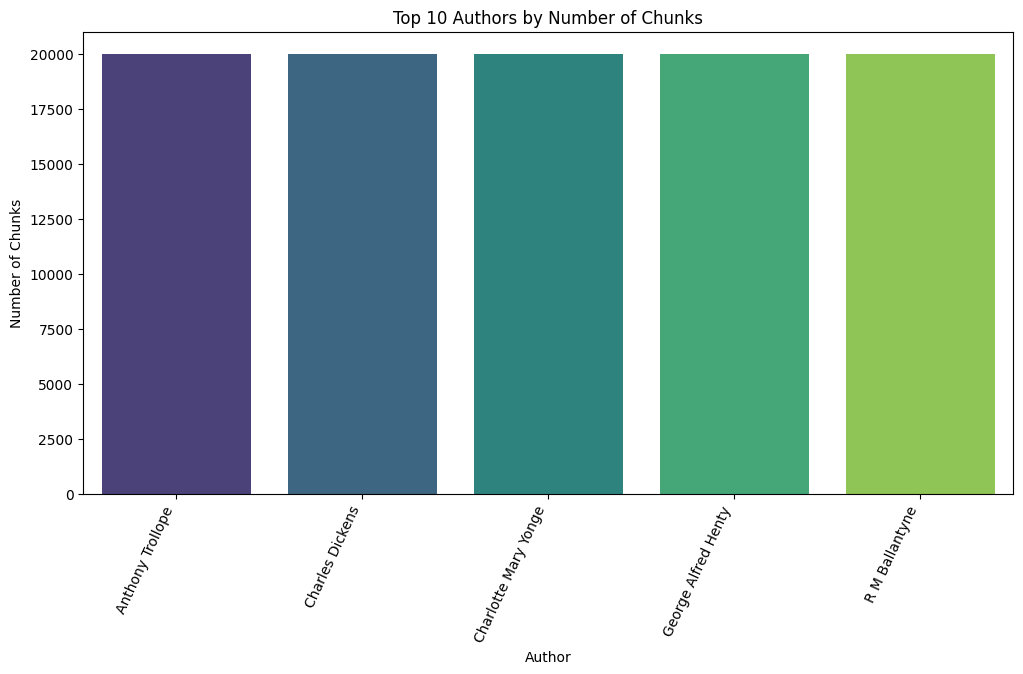


Total Authors: 5
Total Titles (unique books): 369


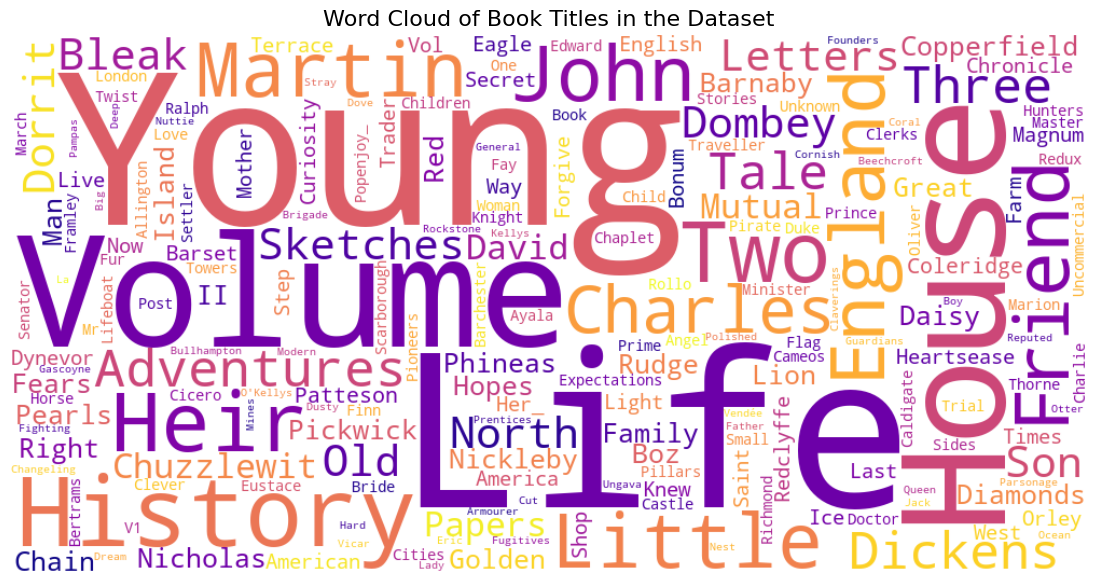

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Start Spark session ---
spark = SparkSession.builder.appName("AuthorEDA").getOrCreate()

# --- Load dataset (~2.9M rows) ---
df = spark.read.csv("dataset_splits/full_chunked.csv", header=True, inferSchema=True)

# -----------------
#  BASIC STATS
# -----------------
total_records = df.count()
unique_authors = df.select("author").distinct().count()
unique_titles = df.select("title").distinct().count()

print(" Dataset Overview")
print(f"Total chunked records: {total_records:,}")
print(f"Unique authors: {unique_authors}")
print(f"Unique titles: {unique_titles}")

# -----------------
# 🎭 GENRE DISTRIBUTION
# -----------------
genre_counts = df.groupBy("genre").count().orderBy(col("count").desc())
genre_counts_pd = genre_counts.toPandas()   # convert to Pandas for plotting

# Pie chart of top 10 genres
top_genres = genre_counts_pd.head(10)
plt.figure(figsize=(8, 8))
plt.pie(top_genres['count'], labels=top_genres['genre'],
        autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Top 10 Genres Distribution")
plt.show()

# -----------------
# 👤 TOP 10 AUTHORS
# -----------------
author_counts = df.groupBy("author").count().orderBy(col("count").desc())
author_counts_pd = author_counts.toPandas()

top_authors = author_counts_pd.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="author", y="count", data=top_authors, palette="viridis")
plt.xticks(rotation=65, ha="right")
plt.title("Top 10 Authors by Number of Chunks")
plt.ylabel("Number of Chunks")
plt.xlabel("Author")
plt.show()

# -----------------
# 📚 HOW MANY AUTHORS / TITLES
# -----------------
print(f"\nTotal Authors: {unique_authors}")
print(f"Total Titles (unique books): {unique_titles}")

# -----------------
# 🌌 WORD CLOUD for TITLES
# -----------------
# Collect all titles (could be 3k unique, repeated across ~2.9M chunks)
titles_pd = df.select("title").toPandas()

# Join all titles into one big string
titles_combined = " ".join(titles_pd['title'].dropna().tolist())

# Generate a word cloud where frequent titles (or words IN titles) are bigger
wordcloud_titles = WordCloud(width=1000, height=500,
                             background_color="white",
                             colormap="plasma",
                             collocations=False).generate(titles_combined)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud_titles, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Book Titles in the Dataset", fontsize=16)
plt.show()

### Step 2 — Preprocessing for LSTM

For our LSTM author classification model, we adopt a **character-level** preprocessing strategy.

1. **Build Character Vocabulary**  
   Extract all unique characters in the training set and map them to integer IDs.  
   (e.g., {'a': 1, 'b': 2, ..., ' ': 27, '!': 28, ...}). Padding is reserved as 0.

2. **Text to Sequences**  
   Convert each text chunk into a sequence of character IDs.

3. **Sequence Padding**  
   Pad or truncate each sequence to a uniform fixed length: **2000 characters**.  
   This ensures consistent tensor inputs for the LSTM.

4. **Author Labels Encoding**  
   Encode string author names into integer labels (0…N-1).

This preprocessing prepares the data in a format suitable for feeding into an LSTM:  
`X_train, X_val, X_test` → padded numeric sequences of chars,  
`y_train, y_val, y_test` → integer author labels.  

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# Load Data
# ---------------------------
train_df = pd.read_csv("dataset_splits/train.csv")
val_df   = pd.read_csv("dataset_splits/val.csv")
test_df  = pd.read_csv("dataset_splits/test.csv")

print("Data loaded")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ---------------------------
# Build Char Vocabulary
# ---------------------------
all_text = "".join(train_df['chunk_text'].astype(str).tolist())
chars = sorted(list(set(all_text)))
char_to_int = {c: i+1 for i, c in enumerate(chars)}  # start idx=1, keep 0 for padding
int_to_char = {i: c for c, i in char_to_int.items()}

print(f"Built vocab of {len(char_to_int)} unique characters")

# ---------------------------
# Encode Text Function
# ---------------------------
def encode_text(text, mapping):
    return [mapping.get(c, 0) for c in text]  # unknown -> 0

train_seqs = [encode_text(t, char_to_int) for t in train_df['chunk_text'].astype(str)]
val_seqs   = [encode_text(t, char_to_int) for t in val_df['chunk_text'].astype(str)]
test_seqs  = [encode_text(t, char_to_int) for t in test_df['chunk_text'].astype(str)]

# ---------------------------
# Stats for Chunk Lengths
# ---------------------------
actual_max = max(
    max(len(seq) for seq in train_seqs),
    max(len(seq) for seq in val_seqs),
    max(len(seq) for seq in test_seqs)
)

print(f"Longest observed chunk length: {actual_max}")

# ---------------------------
# Set MAX_LEN Smartly
# ---------------------------
# Since avg ≈ 400, 75% ≤ 450, max = 500 → best trade-off = 450
MAX_LEN = 450
print("Using MAX_LEN =", MAX_LEN)

# ---------------------------
# Pad Sequences
# ---------------------------
X_train = pad_sequences(train_seqs, maxlen=MAX_LEN, padding='post', truncating='post')
X_val   = pad_sequences(val_seqs,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test  = pad_sequences(test_seqs,  maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# ---------------------------
# Encode Labels (Authors)
# ---------------------------
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['author'])
y_val   = label_encoder.transform(val_df['author'])
y_test  = label_encoder.transform(test_df['author'])

print(f"Encoded {len(label_encoder.classes_)} authors")

# ---------------------------
# Output
# ---------------------------
print("Preprocessing complete! Data ready for LSTM/GRU training")
print("   - X_train, X_val, X_test: Padded int sequences")
print("   - y_train, y_val, y_test: Encoded author labels")
print("char_to_int & int_to_char dictionaries available for encoding/decoding")

Data loaded
Train: 70000, Val: 15000, Test: 15000
Built vocab of 103 unique characters
Longest observed chunk length: 500
Using MAX_LEN = 450
Shapes -> X_train: (70000, 450), X_val: (15000, 450), X_test: (15000, 450)
Encoded 5 authors
Preprocessing complete! Data ready for LSTM/GRU training
   - X_train, X_val, X_test: Padded int sequences
   - y_train, y_val, y_test: Encoded author labels
char_to_int & int_to_char dictionaries available for encoding/decoding


In [5]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import joblib

# # ---------------------------
# # Parameters (from preprocessing results)
# # ---------------------------
# NUM_CLASSES = len(set(y_train))       # should be 5 now
# VOCAB_SIZE  = len(char_to_int) + 1    # +1 for padding index
# MAX_LEN     = 450                     # optimized length
# EMBED_DIM   = 32                      # small, CPU-friendly

# # ---------------------------
# # Build Model (optimized for CPU)
# # ---------------------------
# model = Sequential([
#     Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM,
#               input_length=MAX_LEN, mask_zero=True),
#     Bidirectional(GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
#     Dense(64, activation='relu'),
#     Dropout(0.4),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     metrics=["accuracy"]
# )

# # ---------------------------
# # Callbacks
# # ---------------------------
# early_stop = EarlyStopping(
#     monitor='val_accuracy', patience=2,
#     restore_best_weights=True, verbose=1
# )
# checkpoint = ModelCheckpoint(
#     "checkpoint_best.keras", monitor='val_accuracy',
#     save_best_only=True, verbose=1
# )

# # ---------------------------
# # Training
# # ---------------------------
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=7,
#     batch_size=128,
#     callbacks=[early_stop, checkpoint],
#     verbose=1
# )

# # ---------------------------
# # Evaluate
# # ---------------------------
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
# print(f"🔥 Test Accuracy: {test_acc:.4f}")

# # ---------------------------
# # Save final trained model + label encoder
# # ---------------------------
# model.save("final_author_model.keras")       # saves full model
# joblib.dump(label_encoder, "label_encoder.pkl")
# print("✅ Model and label encoder saved!")

## Evaluation Script (Load + Evaluate & Interpret)

In [6]:
import tensorflow as tf
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, confusion_matrix


model = tf.keras.models.load_model("final_author_model.keras")
label_encoder = joblib.load("label_encoder.pkl")

print("✅ Model and label encoder loaded!")


✅ Model and label encoder loaded!


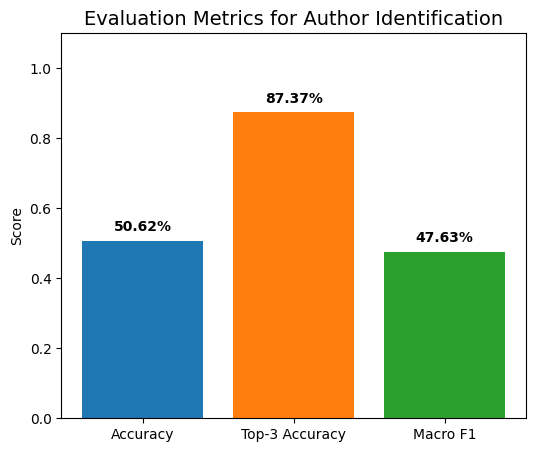

In [7]:
import matplotlib.pyplot as plt

# Compute metrics
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score

y_prob = model.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, y_prob, k=3)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Put metrics into a dictionary
metrics = {
    "Accuracy": acc,
    "Top-3 Accuracy": top3_acc,
    "Macro F1": macro_f1
}

# 🎨 Plot as bar chart
plt.figure(figsize=(6,5))
bars = plt.bar(metrics.keys(), metrics.values(), 
               color=["#1f77b4","#ff7f0e","#2ca02c"])

plt.ylim(0, 1.1)  # leave space above for labels
plt.title("Evaluation Metrics for Author Identification", fontsize=14)
plt.ylabel("Score")


# --- Annotate bars with percentages ---
for bar, value in zip(bars, metrics.values()):
    plt.text(bar.get_x() + bar.get_width()/2, 
             value + 0.02,               # position a bit above bar
             f"{value*100:.2f}%",        # convert to percentage
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

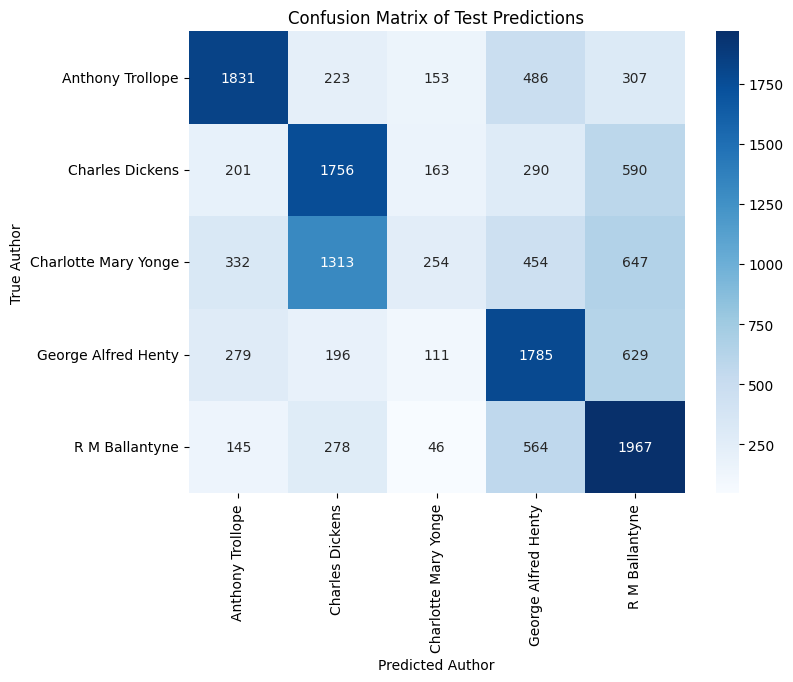

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert back to author names for nice axis labels
author_labels = label_encoder.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=author_labels,
            yticklabels=author_labels)
plt.xlabel("Predicted Author")
plt.ylabel("True Author")
plt.title("Confusion Matrix of Test Predictions")
plt.show()

Total: 15000, Correct: 7593, Wrong: 7407


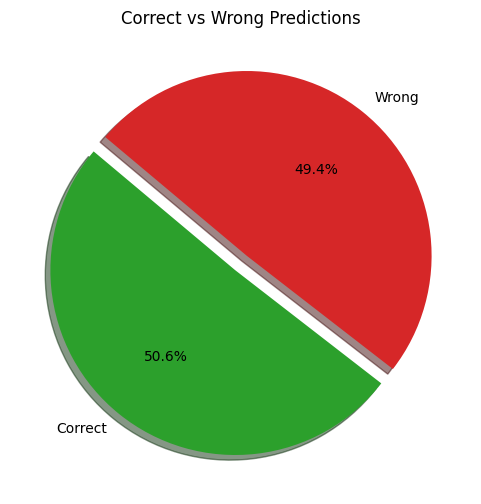


✅ Correct Predictions:
📝 Text: heard the scuffle in the hall. There were kisses;--and a big kiss from Minnie to her much-prized Cousin Fred; and a loud welcome from the full-mouthed rector. "And where is Anna?"--the lord asked. They were the first words he spoke, and she heard the ...
👉 True Author: Anthony Trollope | Predicted: Anthony Trollope
--------------------------------------------------------------------------------
📝 Text: hen she went on with the history of "Rasselas" in his happy valley, by which study Mrs. Thomas intended to initiate her into that course of novel-reading which has become necessary for a British lady. But Mrs. Thomas had a mind to improve the present ...
👉 True Author: Anthony Trollope | Predicted: Anthony Trollope
--------------------------------------------------------------------------------
📝 Text: t what did she say of me I Was she angel on my side of the house as well as yours?" "Of course she was angry." "It did not occur to her that she had been th

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Correct vs Wrong
# ---------------------------
correct_idx = np.where(y_pred == y_test)[0]
misclassified_idx = np.where(y_pred != y_test)[0]

num_correct = len(correct_idx)
num_wrong = len(misclassified_idx)
total = len(y_test)

print(f"Total: {total}, Correct: {num_correct}, Wrong: {num_wrong}")

# Pie chart
plt.figure(figsize=(6,6))
labels = ['Correct', 'Wrong']
sizes = [num_correct, num_wrong]
colors = ['#2ca02c', '#d62728']
explode = (0.05, 0.05)  # slightly "explode" both slices

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140, colors=colors, explode=explode)
plt.title("Correct vs Wrong Predictions")
plt.show()

# ---------------------------
# Preview Examples
# ---------------------------

# Show 3 correct predictions
print("\n✅ Correct Predictions:")
for i in np.random.choice(correct_idx, size=3, replace=False):
    true_author = label_encoder.inverse_transform([y_test[i]])[0]
    pred_author = label_encoder.inverse_transform([y_pred[i]])[0]
    text_sample = test_df.iloc[i]['chunk_text'][:250]  # limit preview length
    
    print("📝 Text:", text_sample, "...")
    print(f"👉 True Author: {true_author} | Predicted: {pred_author}")
    print("-"*80)

# Show 3 misclassified predictions
print("\n❌ Misclassified Predictions:")
for i in np.random.choice(misclassified_idx, size=3, replace=False):
    true_author = label_encoder.inverse_transform([y_test[i]])[0]
    pred_author = label_encoder.inverse_transform([y_pred[i]])[0]
    text_sample = test_df.iloc[i]['chunk_text'][:250]
    
    print("📝 Text:", text_sample, "...")
    print(f"👉 True Author: {true_author} | Predicted: {pred_author}")
    print("-"*80)

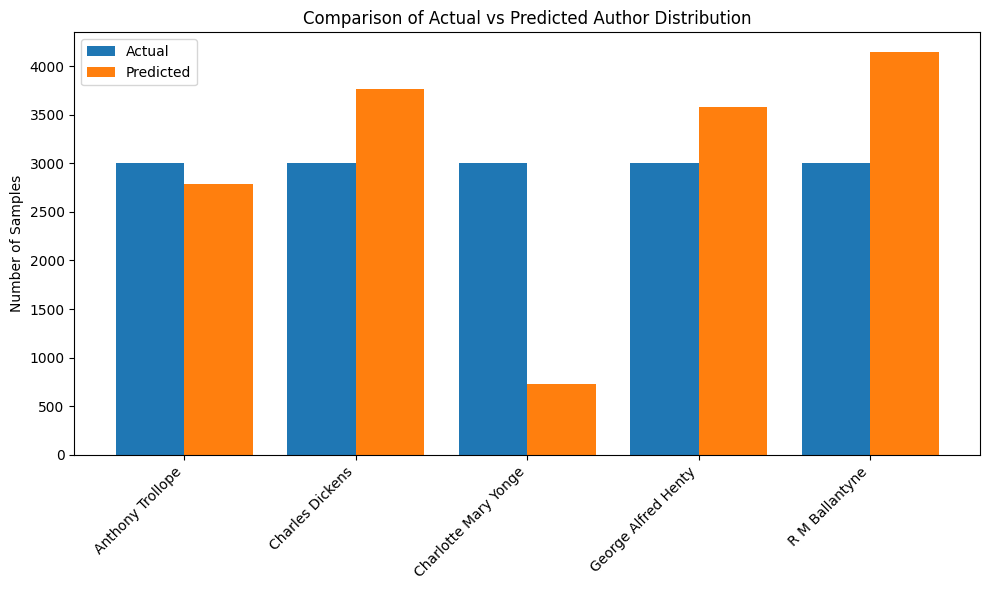

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
#  Count Actual vs Predicted
# ---------------------------
actual_counts = np.bincount(y_test, minlength=len(label_encoder.classes_))
pred_counts   = np.bincount(y_pred, minlength=len(label_encoder.classes_))

authors = label_encoder.classes_

# Put into DataFrame for neat plotting
import pandas as pd

df_compare = pd.DataFrame({
    "Author": authors,
    "Actual": actual_counts,
    "Predicted": pred_counts
})

# ---------------------------
#  Plot Comparison
# ---------------------------
plt.figure(figsize=(10,6))
bar_width = 0.4
x = np.arange(len(authors))

plt.bar(x - bar_width/2, df_compare["Actual"], bar_width, label="Actual", color="#1f77b4")
plt.bar(x + bar_width/2, df_compare["Predicted"], bar_width, label="Predicted", color="#ff7f0e")

plt.xticks(x, authors, rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Comparison of Actual vs Predicted Author Distribution")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from pyspark.sql import SparkSession
import json

# ---------------------------
# 1. Start Spark session
# ---------------------------
spark = SparkSession.builder \
    .appName("RebuildCharVocab") \
    .getOrCreate()

# ---------------------------
# 2. Load train split with PySpark
# ---------------------------
train_df_spark = spark.read.csv("dataset_splits/train.csv", header=True, inferSchema=True)

print(" Data loaded with PySpark")
print(f"Total rows: {train_df_spark.count()}")

# ---------------------------
# 3. Collect chunk_text column into Python list
# ---------------------------
texts = train_df_spark.select("chunk_text").rdd.flatMap(lambda x: x).collect()

# ---------------------------
# 4. Build character vocabulary
# ---------------------------
all_text = "".join([str(t) for t in texts if t is not None])
chars = sorted(list(set(all_text)))

char_to_int = {c: i+1 for i, c in enumerate(chars)}  # reserve 0 for padding
int_to_char = {i: c for c, i in char_to_int.items()}

print(f" Built vocab of {len(char_to_int)} unique characters")

# ---------------------------
# 5. Save mappings to JSON
# ---------------------------
with open("char_to_int.json", "w") as f:
    json.dump(char_to_int, f)

with open("int_to_char.json", "w") as f:
    json.dump(int_to_char, f)

print(" char_to_int and int_to_char saved (no retraining required)!")

# ---------------------------
# 6. Stop Spark session
# ---------------------------
spark.stop()

 Data loaded with PySpark
Total rows: 70000
 Built vocab of 102 unique characters
 char_to_int and int_to_char saved (no retraining required)!


In [18]:
import streamlit as st
import tensorflow as tf
import joblib
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model + encoder + vocab
model = tf.keras.models.load_model("final_author_model.keras")
label_encoder = joblib.load("label_encoder.pkl")
with open("char_to_int.json", "r") as f:
    char_to_int = json.load(f)
MAX_LEN = 450


def encode_text(text, mapping):
    return [mapping.get(c, 0) for c in text]


def predict_author(text, top_k=3):
    seq = encode_text(text, char_to_int)
    seq = pad_sequences([seq], maxlen=MAX_LEN, padding='post')
    probs = model.predict(seq, verbose=0)[0]
    top_indices = np.argsort(probs)[::-1][:top_k]
    preds = [(label_encoder.inverse_transform([i])[0], float(probs[i]))
             for i in top_indices]
    return preds


# Streamlit UI
st.title(" Author Identification Bot")
user_input = st.text_area("Enter some text:", height=150)

if st.button("Predict"):
    if user_input.strip():
        preds = predict_author(user_input, top_k=3)
        st.subheader(" Predictions:")
        for author, prob in preds:
            st.write(f"👉 **{author}**: {prob:.2%}")

2025-09-27 14:14:47.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.122 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 14:14:47.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

SyntaxError: invalid syntax (3737097518.py, line 1)